# Reference

https://stackoverflow.com/questions/31428581/incremental-pca-on-big-data

# Create Dataset

In [26]:
h5.close()

In [29]:
import h5py
import numpy as np
h5 = h5py.File('matrices_big_data.h5', 'w') # approx 5 GB file

vectorSize = 10000
vectorsShape = (1,vectorSize)
numberOfVectorsPerFamily = 20833
randomAmplitude = 0.3

zeroVector = np.zeros(vectorsShape)
onesVector = np.ones(vectorsShape)
oscilatingVector = np.ones(vectorsShape)
for i in range(1,vectorSize,2):
    oscilatingVector[0,i] = -1

h5.create_dataset('data', shape=(3*numberOfVectorsPerFamily,vectorSize), dtype=np.float_)
for i in range(numberOfVectorsPerFamily):
    h5['data'][(3*i+0)*vectorSize:(3*i+1)*vectorSize] = zeroVector + np.random.uniform(low=-randomAmplitude, high=randomAmplitude, size=vectorsShape)
    h5['data'][(3*i+1)*vectorSize:(3*i+2)*vectorSize] = onesVector + np.random.uniform(low=-randomAmplitude, high=randomAmplitude, size=vectorsShape)
    h5['data'][(3*i+2)*vectorSize:(3*i+3)*vectorSize] = oscilatingVector + np.random.uniform(low=-randomAmplitude, high=randomAmplitude, size=vectorsShape)
h5.close()

# Process Data

In [30]:
import h5py
import numpy as np
from sklearn.decomposition import IncrementalPCA

h5 = h5py.File('matrices_big_data.h5')
data = h5['data'] # it's ok, the dataset is not fetched to memory yet

n = data.shape[0] # how many rows we have in the dataset
print('number of rows: {}'.format(n))
chunk_size = 1000 # how many rows we feed to IPCA at a time, the divisor of n
ipca = IncrementalPCA(n_components=5, batch_size=16)

for i in range(0, n//chunk_size):
    ipca.partial_fit(data[i*chunk_size : (i+1)*chunk_size])

number of rows: 62499


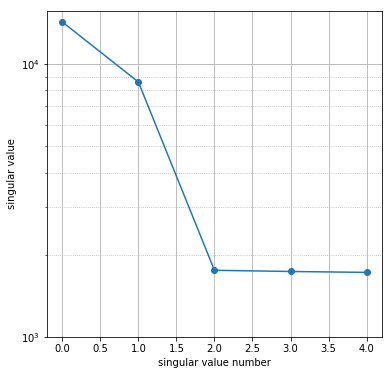

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(range(len(ipca.singular_values_)), ipca.singular_values_, marker='o')
plt.yscale('log')
plt.grid(True)
plt.grid(axis='y', which='minor', b=True, linestyle=':')
plt.xlabel('singular value number')
plt.ylabel('singular value')
plt.ylim([1000, 1.1*np.amax(ipca.singular_values_)])

plt.show()